# Chemical Potentials and Sound Speeds
1. In this notebook, we have arrived at a way to calculate partial derivatives of chemical potentials. This is done by first calculating the chemical potentials symbolically. After we arrive at a symbolic expression for the chemical potential, we then can substitute in numerical values. 
2. Have attempted to calculate sound speed difference and get numerical results but do not match with expected results at the moment. 

In [3]:
# loading in useful, generic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sympy library allows for symbolic manipulation like in Mathematica
import sympy as sym

pi = np.pi
Pi = sym.symbols('pi')

hc = 197.33 # MeV fm
n_sat = 0.16 # fm-3
n0 = 0.153 # fm-3

## Declaring Classes
We declare an EOS class, baryon, lepton, and meson classes. These store values for each thing. For example, each particle class stores the mass, fermi momentum, effective energy, etc for the particles.

For each class, we declare two objects: a numeric object that will store numerical values and a symbolic object that stores the symbols. From the latter we can arrive at a symbolic expression for the partial derivatives and stuff. Then, we can substitute in numerical values (in principle) to perform evaluations.
- The advantage of this approach is that it's easier (hopefully) to see that we have written in the correct expression before inserting numerical values. 

### Equation of State with Coupling Constants
1. Allows for collection of coupling constants here. 
2. In the future could allow for generalization to other RMF-type models albiet at the moment, this would have to be the exact same model but with different coupling values

In [4]:
class eos:
    def __init__(self, g_sigma_N, g_omega_N, g_rho_N, g_phi_N, b, c,\
                    g_sigma_LA, g_omega_LA, g_rho_LA, g_phi_LA):
        
        self.g_sigma_N = g_sigma_N
        self.g_omega_N = g_omega_N
        self.g_rho_N = g_rho_N
        self.g_phi_N = g_phi_N
        
        self.g_sigma_LA = g_sigma_LA
        self.g_omega_LA = g_omega_LA
        self.g_rho_LA = g_rho_LA
        self.g_phi_LA = g_phi_LA
        
        self.b = b
        self.c = c

In [5]:
# initializing numerical eos object 
gm3 = eos(g_sigma_N = 8.784820, g_omega_N = 8.720086, g_rho_N = 8.544795, g_phi_N = 0.0, b = 0.008628, c = -0.002433,\
             g_sigma_LA = 5.408849, g_omega_LA = 5.813391, g_rho_LA = 0.0, g_phi_LA = -4.110688)

# initializing symbolic eos object 
    # declaring symbols 
g_sigma_N, g_omega_N, g_rho_N, g_phi_N, b, c = sym.symbols('g_sigma_N, g_omega_N, g_rho_N, g_phi_N, b, c')
g_sigma_LA, g_omega_LA, g_rho_LA, g_phi_LA = sym.symbols('g_sigma_Lambda, g_omega_Lamda, g_rho_Lambda, g_phi_Lambda')

# initializing symbolic eos object
gm3_sym = eos(g_sigma_N, g_omega_N, g_rho_N, g_phi_N, b, c,\
                    g_sigma_LA, g_omega_LA, g_rho_LA, g_phi_LA)

### Sigma Field Self Interaction Term
$$
    U(\sigma) = \frac{1}{3}bm_N (g_\sigma \sigma)^3 + \frac{1}{4}c(g_\sigma \sigma)^4
$$

In [6]:
U = sym.Function('U')

### Baryons, Leptons
1. Declaring classes for baryons, leptons. Allows us to declare a baryon and lepton object that has the relevant data for each type of particle such as mass, charge, Fermi momentum, etc. 
2. The purpose of this is that we first arrive at an expression for the partial derivative of the chemical potentials symbolically. After that, we could then substitute in numerical values.
3. The symbolic particles have their named followed by a sym suffix. The numeric objects ahve their name followed by a num suffix. 

#### Declaring Numeric Classes

In [7]:
class baryon:
    def __init__(self, mass, isospin, charge, kind, var_type, mass_eff = 0.0, num_density = 0.0,\
                 frac = 0.0, kf = 0.0, ef = 0.0, chem_pot = 0.0):
    
        # variables to be established at baryon declaration
        self.mass = mass
        self.isospin = isospin
        self.charge = charge
        self.kind = kind
        self.var_type = var_type
    
        # variables to be stored later
        self.mass_eff = mass_eff
        self.num_density = num_density
        self.frac = frac
        self.kf = kf
        self.ef = ef
        self.chem_pot = chem_pot

class lepton:
    def __init__(self, mass, charge, num_density = 0.0, frac = 0.0, var_type = 0.0, kf = 0.0, chem_pot = 0.0):
        self.mass = mass
        self.charge = charge
        self.num_density = num_density
        self.frac = frac
        self.var_type = var_type
        self.kf = kf
        self.chem_pot = chem_pot

Initializing the symbolic and numeric particle objects

In [8]:
# electron
electron_sym = lepton(sym.symbols('m_e'), -1, sym.symbols('n_e'), sym.symbols('x_e'), 'Independent',\
                      sym.symbols('k_F_e'), sym.symbols('\mu_e'))
electron_num = lepton(0.510, -1)


# lambda hyperon
lambda_sym = baryon(sym.symbols('m_Lambda'), 0.0, 0.0, 'Hyperon', 'Independent', sym.symbols('m_Lambda^*'),\
                    sym.symbols('n_Lambda'), sym.symbols('x_Lambda'), sym.symbols('k_F_Lambda'),\
                    sym.symbols('E^*_F_Lambda'), sym.symbols('mu_Lambda'))
lambda_num = baryon(1116.0, 0, 0, 'Hyperon', 'Independent')


# proton 
proton_sym = baryon(sym.symbols('m_p'), 1/2, 1, 'Nucleon', 'Dependent', sym.symbols('m_p^*'),\
                    sym.symbols('n_p'), sym.symbols('x_p'), sym.symbols('k_F_p'),\
                    sym.symbols('E^*_F_p'), sym.symbols('mu_p'))
proton_num = baryon(939.0, 1/2, 1, 'Nucleon', 'Dependent')


# neutron 
neutron_sym = baryon(sym.symbols('m_n'), -1/2, 0, 'Nucleon', 'Dependent', sym.symbols('m_n^*'),\
                    sym.symbols('n_n'), sym.symbols('x_n'), sym.symbols('k_F_n'),\
                    sym.symbols('E^*_F_n'), sym.symbols('mu_n'))
neutron_num = baryon(939.0, -1/2, 0, 'Nucleon', 'Dependent')

### Declaring Independent Variable Class
1. Stores information for an independent variable such as its symbolic representation and numeric value. 

In [9]:
class independent_var:
    def __init__(self, var, func, tilde_chem_pot = 0.0, tilde_chem_pot_val = 0.0, num_val = 0.0, total_deriv = 0.0):
        self.var = var # var is the symbol for the variable
        self.func = func 
        
        self.tilde_chem_pot = tilde_chem_pot
        self.tilde_chem_pot_val = tilde_chem_pot_val
        
        self.num_val = num_val
        
        # total derivative of fraction wrt to nB
        self.total_deriv = total_deriv

In [10]:
# initializing independent variables
nb = independent_var(sym.symbols('n_B'), sym.Function('n_B'))
xe = independent_var(sym.symbols('x_e'), sym.Function('x_e'), sym.symbols('mu tilde_x_e'))
xl = independent_var(sym.symbols('x_Lambda'), sym.Function('x_Lambda'), sym.symbols('mu tilde_x_Lambda'))

In [11]:
# re-write proton and neutron number densities and fractions in terms of independent ones
proton_sym.num_density = nb.var*(xe.var)
proton_sym.frac = xe.var

neutron_sym.num_density = nb.var*(1 - xe.var - xl.var)
neutron_sym.frac = 1 - xe.var - xl.var

### Mesons

In [12]:
class meson:
    def __init__(self, mass, field = 0.0):
        self.mass = mass # in MeV
        self.field = 0.0 

In [13]:
# declaring the symbolic meson objects
sigma_sym = meson(sym.symbols('m_sigma'), sym.symbols('sigma'))
omega_sym = meson(sym.symbols('m_omega'), sym.symbols('omega'))
rho_sym = meson(sym.symbols('m_rho'), sym.symbols('rho'))
phi_sym = meson(sym.symbols('m_phi'), sym.symbols('phi'))

# declaring the numeric meson objects
sigma_num = meson(550.0)
omega_num = meson(783.0)
rho_num = meson(770.0)
phi_num = meson(1020.0)

### Establishing Helpful Lists
1. Consolidating all the objects into helpful lists to be summed over. 

In [14]:
# Making a list of the independent variables
independent_variables = [nb, xe, xl]

# List of symbolic and numeric baryon objects
baryon_list = [proton_sym, neutron_sym, lambda_sym]
baryon_num_list = [proton_num, neutron_num, lambda_num]

# List of symbolic and numeric lepton objects (just electrons for now)
lepton_list = [electron_sym]
lepton_num_list = [electron_num]

# List of symbolic and numeric meson objects
meson_list = [sigma_sym, omega_sym, rho_sym, phi_sym]
meson_num_list = [sigma_num, omega_num, rho_num, phi_num]

#### Baryon and Lepton Chemical Potentials
1. Though not strictly relevant (except for the neutron chemical potential), we include these here at the beginning so they can be declared when needed. These return the chemical potentials (not the partial derivatives)

In [15]:
def baryon_chemical_potential(baryon):
    if (baryon.kind == 'Nucleon'):
        #baryon.chem_pot = np.sqrt(baryon.kf**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
        #            + gm3.g_phi_N*phi_num.field + baryon.isospin*gm3.g_rho_N*rho_num.field
        return np.sqrt(baryon.kf**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
                    + gm3.g_phi_N*phi_num.field + baryon.isospin*gm3.g_rho_N*rho_num.field
    elif (baryon.kind == 'Hyperon'):
        #baryon.chem_pot = np.sqrt(baryon.kf**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
        #            + gm3.g_phi_N*phi_num.field + baryon.isospin*gm3.g_rho_N*rho_num.field
        return np.sqrt(baryon.kf**2 + baryon.mass_eff**2) + gm3.g_omega_LA*omega_num.field\
                    + gm3.g_phi_LA*phi_num.field + baryon.isospin*gm3.g_rho_LA*rho_num.field
    
def baryon_chemical_potential_test(baryon):
    if (baryon.kind == 'Nucleon'):
        baryon.chem_pot = np.sqrt((baryon.kf-gm3.g_omega_N*omega_num.field - gm3.g_rho_N*rho_num.field*baryon.isospin)**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
                     + baryon.isospin*gm3.g_rho_N*rho_num.field
        return np.sqrt((baryon.kf-gm3.g_omega_N*omega_num.field - gm3.g_rho_N*rho_num.field*baryon.isospin)**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
                     + baryon.isospin*gm3.g_rho_N*rho_num.field
    elif (baryon.kind == 'Hyperon'):
        baryon.chem_pot = np.sqrt((baryon.kf-gm3.g_omega_LA*omega_num.field - gm3.g_rho_LA*rho_num.field*baryon.isospin)**2 + baryon.mass_eff**2) + gm3.g_omega_N*omega_num.field\
                     + baryon.isospin*gm3.g_rho_N*rho_num.field
        return np.sqrt(((baryon.kf-gm3.g_omega_LA*omega_num.field - gm3.g_rho_LA*rho_num.field*baryon.isospin)**2)**2 + baryon.mass_eff**2) + gm3.g_omega_LA*omega_num.field\
                    + baryon.isospin*gm3.g_rho_LA*rho_num.field
    
def lepton_chemical_potential(lepton):
    return np.sqrt(lepton.kf**2 + lepton.mass**2)

## Lepton/Electron Chemical Potential Derivative
$$
    \mu_e = \sqrt{k_{F_e}^2 + m_e^2} \qquad k_{F_e} = (3\pi^2 n_e)^{1/3} \qquad 
       n_e = n_B x_e
$$

In [17]:
def chem_pot_electron(x_j):
    # calculates derivative of electron chemical potential wrt variable x_j
    mu_e = sym.sqrt(electron_sym.kf**2 + electron_sym.mass**2)
    mu_e = mu_e.subs(electron_sym.kf, (3*Pi**2*sym.symbols('n_B')*electron_sym.frac)**(sym.S(1)/3))
    return mu_e.diff(x_j)

In [18]:
# sample 
chem_pot_electron(nb.var)

3**(2/3)*(n_B*pi**2*x_e)**(2/3)/(3*n_B*sqrt(m_e**2 + 3**(2/3)*(n_B*pi**2*x_e)**(2/3)))

# Working towards Baryon Chemical Potential Partial Derivatives
The Baryon chemical potential expression that we have is given by 
$$
    \mu_i = \mu_i^* + g_{\omega i}\omega_0 + g_{\phi i}\phi_0 + I_{3B}g_{\rho i}\rho_0 \qquad \mu_i^* = \sqrt{k_{F_i}^2 + {m_i^*}^2}
$$

Ultimately, we want to write down a function that takes a baryon $i$ and an independent variable $x_j$ and returns the partial derivative of the chemical potential of baryon $i$ with respect to $x_j$. That is,

$$
    \frac{\partial \mu_i}{\partial x_j} = \frac{\partial \mu_i^*}{\partial x_j} + \frac{\partial \mu_i^R}{\partial x_j}
$$

where 

$$
    \frac{\partial \mu_i^*}{\partial x_j} = \frac{\partial }{\partial x_j}\sqrt{k_{F_i}^2 + {m_i^*}^2}
    \qquad
    \frac{\partial \mu_i^R}{\partial x_j} = g_{\omega i}\frac{\partial \omega_0}{\partial x_j} + g_{\phi i}\frac{\partial \phi_0}{\partial x_j} + I_{3B}g_{\rho i}\frac{\partial \rho_0}{\partial x_j}
$$

This task is broken down as follows:
- Calculate  $\partial \mu_i^R/\partial x_j$ and $\partial \mu_i^*/\partial x_j$
    - For the first task, we need to calculate partial derivatives of meson fields and then multiply by relevant coupling constants 
    - For the second task, then need to find the partial derivative of the effective energy. This then amounts to finding the partial derivative of the sigma fields and partial derivatives of the Fermi momentum with respect to the independent variable.
    
With this in mind, let us start from the bottom and work ourselves back up.

## Task 1: Working Towards $\partial \mu^R_i/\partial x_j$

#### Task 1a: Calculating Partial Derivatives of Meson Fields with respect to independent variable $x_j$
1. Goal here: write a function that takes as input independent variable $x_j$ and returns $\partial \omega_0/\partial x_j$ and more.
2. At the moment, we have three functions. But in principle, they are all quite similar. Could try to generalize this by associating to each meson class object an 'Equation of state' function as well as their relevant coupling constants. Would allow us to condense these three equations into one single equation.

In [19]:
def partial_omega(x_j):
    # returns domega/dxj
    omega_sym.field = 0
    
    # equation of motion 
    for i in range(len(baryon_list)):
        if(baryon_list[i].kind == 'Nucleon'):
            omega_sym.field = gm3_sym.g_omega_N*nb.var*baryon_list[i].frac + omega_sym.field
        elif(baryon_list[i].kind == 'Hyperon'):
            omega_sym.field = gm3_sym.g_omega_LA*nb.var*baryon_list[i].frac + omega_sym.field
        
    omega_sym.field = 1/omega_sym.mass**2*omega_sym.field 

    # calculate partial derivative 
    return sym.collect(omega_sym.field.diff(x_j), gm3_sym.g_omega_N)

In [20]:
def partial_rho(x_j):
    # returns drho/dxj
    rho_sym.field = 0 
    
    # equation of motion
    # in the future would be good to call the equation of motion directly here... from Lagrangian
    for i in range(len(baryon_list)):
        if(baryon_list[i].kind == 'Nucleon'):
            rho_sym.field = gm3_sym.g_rho_N*baryon_list[i].frac*nb.var*baryon_list[i].isospin + rho_sym.field
        elif(baryon_list[i].kind == 'Hyperon'):
            rho_sym.field = gm3_sym.g_rho_LA*baryon_list[i].frac*nb.var*baryon_list[i].isospin + rho_sym.field
    
    rho_sym.field = 1/rho_sym.mass**2*rho_sym.field
    
    # calculate partial derivative
    return sym.simplify(rho_sym.field.diff(x_j))

In [21]:
def partial_phi(x_j):
    # returns dmeson/dxj
    phi_sym.field = 0
    
    # equation of motion 
    for i in range(len(baryon_list)):
        if(baryon_list[i].kind == 'Nucleon'):
            phi_sym.field = gm3_sym.g_phi_N*baryon_list[i].frac*nb.var + phi_sym.field
        elif(baryon_list[i].kind == 'Hyperon'):
            phi_sym.field = gm3_sym.g_phi_LA*baryon_list[i].frac*nb.var + phi_sym.field
        
    phi_sym.field = 1/phi_sym.mass**2*phi_sym.field 
    
    # calculate partial derivative 
    return sym.simplify(phi_sym.field.diff(x_j))

### Task 1b: Arriving at expression for Partial Derivative of $\mu_i^R$
Where 
$$
    \mu_i^R = g_{\omega i}\omega + g_{\phi i}\phi + I_{3B}g_{\rho i}\rho
$$
and 
$$
    \frac{\partial \mu_i^R}{\partial x_j} = g_{\omega i}\frac{\partial \omega}{\partial x_j} + g_{\phi i}\frac{\partial \phi}{\partial x_j} + I_{3B}g_{\rho i}\frac{\partial \rho}{\partial x_j}
$$

In [22]:
def partial_mu_R(baryon_sym, x_j):
    # returns dmu_i^R/dx_j
    
    # checks if baryon is a nucleon or hyperon as they have different
    # coupling constants
    
    if(baryon_sym.kind == 'Nucleon'):
        return gm3_sym.g_omega_N*partial_omega(x_j) + gm3_sym.g_phi_N*partial_phi(x_j)\
            + baryon_sym.isospin*gm3_sym.g_rho_N*partial_rho(x_j)
    
    elif(baryon_sym.kind == 'Hyperon'):
        return gm3_sym.g_omega_LA*partial_omega(x_j) + gm3_sym.g_phi_LA*partial_omega(x_j)\
            + baryon_sym.isospin*gm3_sym.g_rho_LA*partial_rho(x_j)

## Task 2: Working towards $\partial \mu_i*/\partial x_j$
We have the following expression for 
$$
    \frac{\partial \mu_i'}{\partial x_j} = \frac{\partial }{\partial x_j}\sqrt{k_{F_i}^2 + {m_i^*}^2}
    = \frac{1}{2}\frac{k_{F_i}\dfrac{\partial k_{F_i}}{\partial x_j} - g_{\sigma i}m_i^* \dfrac{\partial\sigma}{\partial x_j}}{\sqrt{k_{F_i}^2 + {m_i^*}^2}}
$$
which depends on 
$$
    \frac{\partial k_{F_i}}{\partial x_j} \qquad \frac{\partial\sigma}{\partial x_j}
$$

### Task 2a: Calculating $\frac{\partial k_{F_i}}{\partial x_j}$ with respect to independent variables
1. We have two functions that can do this. First does this by substituting in fully for the Fermi momentum and asking python to take and return the derivative for us. The second function, we calculate the derivative by hand and write in it directly in terms of the Fermi momentum which is a cleaner result. The two results may look different but end up being equivalent. 

In [23]:
def partial_fermi_old(baryon_sym, x_j):
    # assumes baryon number density has already been re-written in terms of independent variables at the beginning
    kFi = (3*Pi**2*nb.var*baryon_sym.frac)**(sym.S(1)/3)
    return kFi.diff(x_j)

In [24]:
# sample: calculating derivative of proton momentum wrt to nB
partial_fermi_old(proton_sym, nb.var)

3**(1/3)*(n_B*pi**2*x_e)**(1/3)/(3*n_B)

In [25]:
def partial_fermi(baryon_sym, x_j):
    kFi_sort_of = (Pi**2*nb.var*baryon_sym.frac)/baryon_sym.kf**2
    return kFi_sort_of.diff(x_j)

In [26]:
# sample: calculating derivative of proton momentum wrt to nB
partial_fermi(proton_sym, nb.var)

pi**2*x_e/k_F_p**2

### Task 2b: Calculate $\partial \sigma/\partial x_j$
From the notes, we have
$$
    \frac{\partial \sigma}{\partial x_j} = \frac{\sum_i g_{\sigma i} \beta_i \dfrac{\partial k_{F_i}}{\partial x_j}}{m_\sigma^2 + \dfrac{\partial^2 U}{\partial \sigma^2} - \sum_i g_{\sigma i}\alpha_i}
$$
where
$$
    \alpha_i = \left[\frac{3}{2}\frac{g_{\sigma i}{m_i^*}^2}{\pi^2}
        \ln\frac{k_{F_i} + E_{F_i}}{m_i^*} -\frac{g_{\sigma i}}{\pi^2}\left(\frac{1}{2}k_{F_i}E_{F_i} + {m_i^*}^2\frac{k_{F_i}}{E_{F_i}}\right)\right]
$$
and
$$
    \beta_i = \frac{m_i^*}{\pi^2}\frac{k_{F_i}^2}{E_{F_i}}
$$

We have alpha given here but as we see, the code is a little ugly and redundant. We can improve this by using a sub class hopefully? Not esssential I guess.

In [27]:
def alpha(baryon_sym):
    # takes a baryon and returns alpha as defined above
    if (baryon_sym.kind == 'Nucleon'):
        g_sigma = gm3_sym.g_sigma_N 
    elif (baryon_sym.kind == 'Hyperon'):
        g_sigma = gm3_sym.g_sigma_LA 
        
    term1 = (sym.S(3)/2)*(1/Pi**2)*g_sigma*baryon_sym.mass_eff**2*sym.log((baryon_sym.kf + baryon_sym.ef)/baryon_sym.mass_eff)
    term2 = (sym.S(1)/2)*baryon_sym.kf*baryon_sym.ef 
    term3 = baryon_sym.mass_eff**2*baryon_sym.kf/baryon_sym.ef
    
    return term1 - g_sigma/Pi**2*(term2 + term3)

def beta(baryon_sym):
    # takes a baryon and returns beta as defined above
    return baryon_sym.mass_eff*baryon_sym.kf**2/Pi**2/baryon_sym.ef

In [28]:
# samples 
alpha(proton_sym)

3*g_sigma_N*m_p^***2*log((E^*_F_p + k_F_p)/m_p^*)/(2*pi**2) - g_sigma_N*(E^*_F_p*k_F_p/2 + k_F_p*m_p^***2/E^*_F_p)/pi**2

In [29]:
# sample 
beta(lambda_sym)

k_F_Lambda**2*m_Lambda^*/(E^*_F_Lambda*pi**2)

Now that we have our two ''unknowns'' we can plug back into the specified expression for partial sigma.

In [30]:
def partial_sigma(x_j):
    # returns dsigma/dx_j
    
    numerator = 0 
    denominator = sigma_sym.mass**2 + sym.diff(U(sym.symbols('sigma')),sym.symbols('sigma'),sym.symbols('sigma'))
    for i in range(len(baryon_list)):
        if (baryon_list[i].kind == 'Nucleon'):
            numerator = numerator + gm3_sym.g_sigma_N*beta(baryon_list[i])*partial_fermi(baryon_list[i], x_j)
            denominator = denominator - gm3_sym.g_sigma_N*alpha(baryon_list[i])
        elif (baryon_list[i].kind == 'Hyperon'):
            numerator = numerator + gm3_sym.g_sigma_LA*beta(baryon_list[i])*partial_fermi(baryon_list[i], x_j)
            denominator = denominator - gm3_sym.g_sigma_LA*alpha(baryon_list[i])
    
    return numerator/denominator

In [31]:
# sample: calculating dsigma/dnB
partial_sigma(nb.var)

(g_sigma_N*m_p^**x_e/E^*_F_p + g_sigma_N*m_n^**(-x_Lambda - x_e + 1)/E^*_F_n + g_sigma_Lambda*m_Lambda^**x_Lambda/E^*_F_Lambda)/(-g_sigma_Lambda*(3*g_sigma_Lambda*m_Lambda^***2*log((E^*_F_Lambda + k_F_Lambda)/m_Lambda^*)/(2*pi**2) - g_sigma_Lambda*(E^*_F_Lambda*k_F_Lambda/2 + k_F_Lambda*m_Lambda^***2/E^*_F_Lambda)/pi**2) - g_sigma_N*(3*g_sigma_N*m_n^***2*log((E^*_F_n + k_F_n)/m_n^*)/(2*pi**2) - g_sigma_N*(E^*_F_n*k_F_n/2 + k_F_n*m_n^***2/E^*_F_n)/pi**2) - g_sigma_N*(3*g_sigma_N*m_p^***2*log((E^*_F_p + k_F_p)/m_p^*)/(2*pi**2) - g_sigma_N*(E^*_F_p*k_F_p/2 + k_F_p*m_p^***2/E^*_F_p)/pi**2) + m_sigma**2 + Derivative(U(sigma), (sigma, 2)))

### Task 2c: Arriving at expression for $\partial \mu'_i/\partial x_j$
With both $    \frac{\partial k_{F_i}}{\partial x_j}$ and $\frac{\partial\sigma}{\partial x_j}$ in hand, we have 
$\partial \mu'_i/\partial x_j$ via 
$$
    \frac{\partial \mu_i'}{\partial x_j} = \frac{\partial }{\partial x_j}\sqrt{k_{F_i}^2 + {m_i^*}^2}
    = \frac{k_{F_i}\dfrac{\partial k_{F_i}}{\partial x_j} - g_{\sigma i}m_i^* \dfrac{\partial\sigma}{\partial x_j}}{\sqrt{k_{F_i}^2 + {m_i^*}^2}}
$$

In [32]:
def partial_mu_prime(baryon, x_j):
    if (baryon.kind == 'Nucleon'):
        return 1/sym.sqrt(baryon.kf**2 + baryon.mass_eff**2)*(baryon.kf*partial_fermi(baryon, x_j)\
                - gm3_sym.g_sigma_N*baryon.mass_eff*partial_sigma(x_j))
    elif (baryon.kind == 'Hyperon'):
        return 1/sym.sqrt(baryon.kf**2 + baryon.mass_eff**2)*(baryon.kf*partial_fermi(baryon, x_j)\
                - gm3_sym.g_sigma_LA*baryon.mass_eff*partial_sigma(x_j))

##  Adding $\partial \mu^*_i/\partial x_j$ and $\partial \mu^R_i/\partial x_j$ together to get the Chemical Potential Partial Derivative: $\partial \mu_i/\partial x_j$
From $$
    \frac{\partial \mu_i}{\partial x_j} = \frac{\partial \mu_i^*}{\partial x_j} + \frac{\partial \mu_i^R}{\partial x_j}
$$


In [33]:
def chem_pot_part_deriv(baryon, x_j):
    return partial_mu_prime(baryon, x_j) + partial_mu_R(baryon, x_j)

For visualization, we calculate the partial derivative of the proton chemical potential with respect to $n_B$. We see that it is not a fun expression. 

In [34]:
chem_pot_part_deriv(proton_sym, nb.var)

g_omega_N*(g_omega_Lamda*x_Lambda + g_omega_N*(1 - x_Lambda))/m_omega**2 + g_phi_N*(g_phi_Lambda*x_Lambda - g_phi_N*x_Lambda + g_phi_N)/m_phi**2 + 0.25*g_rho_N**2*(x_Lambda + 2*x_e - 1)/m_rho**2 + (-g_sigma_N*m_p^**(g_sigma_N*m_p^**x_e/E^*_F_p + g_sigma_N*m_n^**(-x_Lambda - x_e + 1)/E^*_F_n + g_sigma_Lambda*m_Lambda^**x_Lambda/E^*_F_Lambda)/(-g_sigma_Lambda*(3*g_sigma_Lambda*m_Lambda^***2*log((E^*_F_Lambda + k_F_Lambda)/m_Lambda^*)/(2*pi**2) - g_sigma_Lambda*(E^*_F_Lambda*k_F_Lambda/2 + k_F_Lambda*m_Lambda^***2/E^*_F_Lambda)/pi**2) - g_sigma_N*(3*g_sigma_N*m_n^***2*log((E^*_F_n + k_F_n)/m_n^*)/(2*pi**2) - g_sigma_N*(E^*_F_n*k_F_n/2 + k_F_n*m_n^***2/E^*_F_n)/pi**2) - g_sigma_N*(3*g_sigma_N*m_p^***2*log((E^*_F_p + k_F_p)/m_p^*)/(2*pi**2) - g_sigma_N*(E^*_F_p*k_F_p/2 + k_F_p*m_p^***2/E^*_F_p)/pi**2) + m_sigma**2 + Derivative(U(sigma), (sigma, 2))) + pi**2*x_e/k_F_p)/sqrt(k_F_p**2 + m_p^***2)

# Numerical Calculations
1. We have a symbolic expression for the chemical potential partial derivatives. In this part, we want to then get the numerical expressions. We substitute in for all variables the values of the fields, masses, coupling constants, fractions, etc. The plan here is to take the data from the data file and for each data row (ie, for a given nB and other fixed fractions and stuff) and store that in the numeric baryon class. Assuming that is done, we can then perform the substitution.

## Loading in Data

In [35]:
data = pd.read_csv(r'/Users/vinhtran/Downloads/datafile_gm3.txt', sep=" ", header=0,\
                       names = ['nb/n0', 'P', 'E', 'Sigma', 'Rho','Omega', 'Phi', 'xn', 'xp',\
                            'xe', 'xL', 'fermi_n', 'fermi_p', 'fermi_e', 'fermi_L', 'nan'])
data

,nb/n0,P,E,Sigma,Rho,Omega,Phi,xn,xp,xe,xL,fermi_n,fermi_p,fermi_e,fermi_L,nan
0,0.28,0.070686,40.349774,8.198005,-2.328705,4.681230,-0.000000,0.990944,0.009056,0.009056,0.000000,212.949950,44.522679,44.522679,0.000000,NaN
1,0.29,0.080052,41.793525,8.453906,-2.409592,4.848417,-0.000000,0.990479,0.009521,0.009521,0.000000,215.421820,45.803502,45.803502,0.000000,NaN
2,0.30,0.090248,43.237612,8.707875,-2.490287,5.015604,-0.000000,0.990008,0.009992,0.009992,0.000000,217.835457,47.075844,47.075844,0.000000,NaN
3,0.31,0.101300,44.682054,8.959955,-2.570788,5.182791,-0.000000,0.989530,0.010470,0.010470,0.000000,220.194014,48.339953,48.339953,0.000000,NaN
4,0.32,0.113235,46.126866,9.210186,-2.651092,5.349977,-0.000000,0.989046,0.010954,0.010954,0.000000,222.500376,49.596057,49.596057,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,7.96,424.462572,1518.141189,76.157712,-19.387450,110.614440,-18.722709,0.390550,0.103000,0.103000,0.506450,476.509635,305.580406,305.580406,519.627154,NaN
769,7.97,425.578051,1520.582346,76.195184,-19.389709,110.732982,-18.763248,0.390156,0.102934,0.102934,0.506910,476.548918,305.642795,305.642795,520.001921,NaN
770,7.98,426.695085,1523.024904,76.232608,-19.391960,110.851508,-18.803800,0.389763,0.102868,0.102868,0.507369,476.588102,305.705038,305.705038,520.376269,NaN
771,7.99,427.813675,1525.468863,76.269983,-19.394204,110.970019,-18.844365,0.389371,0.102802,0.102802,0.507827,476.627187,305.767137,305.767137,520.750198,NaN


Extract each column and store into its own array

In [36]:
nb_array = data.loc[:,'nb/n0'].values
P_array = data.loc[:,'P'].values
E_array = data.loc[:,'E'].values
sigma_array = data.loc[:,'Sigma'].values
rho_array = data.loc[:,'Rho'].values
omega_array = data.loc[:,'Omega'].values
phi_array = data.loc[:,'Phi'].values

neutron_frac = data.loc[:, 'xn'].values
proton_frac = data.loc[:, 'xp'].values
electron_frac = data.loc[:, 'xe'].values
lambda_frac = data.loc[:, 'xL'].values

fermi_n = data.loc[:, 'fermi_n'].values
fermi_p = data.loc[:, 'fermi_p'].values
fermi_e = data.loc[:, 'fermi_e'].values
fermi_L = data.loc[:, 'fermi_L'].values

#### Define a load values function
1. Each row in the table of data above represents a given instance of the system. We can then load in all the values in a given row into our numerical baryon, lepton, independent variables objects. The function takes an integer as argument which corresponds to the index/row number. 

In [54]:
def load_values(i):
    # load in values to numerical baryon object from data table 
    
    n0 = 0.153
    
    # re-write baryon density in MeV^3 
    # this would yield the correct fermi momentum values as given in the data
    nb.num_val = nb_array[i]*n0*hc**3
    
    # allocate values
    
    # meson field values 
    sigma_num.field = sigma_array[i]
    rho_num.field = rho_array[i]
    omega_num.field = omega_array[i]
    phi_num.field = phi_array[i]
    
    # particle fractions
    neutron_num.frac = neutron_frac[i]
    proton_num.frac = proton_frac[i]
    electron_num.frac = electron_frac[i]
    lambda_num.frac = lambda_frac[i]
    
    # particle fermi momentum 
    neutron_num.kf = fermi_n[i]
    proton_num.kf = fermi_p[i]
    electron_num.kf = fermi_e[i]
    lambda_num.kf = fermi_L[i]
    
    # effective masses
    neutron_num.mass_eff = neutron_num.mass - gm3.g_sigma_N*sigma_array[i]
    proton_num.mass_eff = proton_num.mass - gm3.g_sigma_N*sigma_array[i]
    lambda_num.mass_eff = lambda_num.mass - gm3.g_sigma_LA*sigma_array[i]
    
    # need to fill in eff values!!
    neutron_num.ef = np.sqrt(neutron_num.kf**2 + neutron_num.mass_eff**2)
    proton_num.ef = np.sqrt(neutron_num.kf**2 + proton_num.mass_eff**2)
    lambda_num.ef = np.sqrt(neutron_num.kf**2 + lambda_num.mass_eff**2)
        
    # can fill in chemical potentials 
    neutron_num.chem_pot = baryon_chemical_potential(neutron_num)
    proton_num.chem_pot = baryon_chemical_potential(proton_num)
    lambda_num.chem_pot = baryon_chemical_potential(lambda_num)
    
    # can fill in num. densities, although we don't use them directly as we re-write everything
    # in terms of nB, xe
    neutron_num.num_density = nb.num_val*neutron_num.frac
    proton_num.num_density = nb.num_val*proton_num.frac
    lambda_num.num_density = nb.num_val*lambda_num.frac

## Numerical Methods

### Numerical Electron Chemical Potential Function

In [38]:
def chem_pot_electron_num(ind_var):
    # takes symbolic electron chemical potential partial derivative
    # and returns numeric expression using information stored in electron_sym and 
    # electron_num objects. Idea is that electron_sym contains symbols like m_e and electron_num contains
    # numerical values for those symbols like: m_e = 0.510 MeV
    
    # load in symbolic expression 
    
    symbolic = chem_pot_electron(ind_var)

    # replace symbolic variables using sympy subs method 
    symbolic = symbolic.subs([(Pi, np.pi), (electron_sym.mass, electron_num.mass),\
        (electron_sym.frac, electron_num.frac), (nb.var, nb.num_val)])
    
    return sym.simplify(symbolic)

### Numerical Baryon Chemical Potential Derivative Function
1. We have the symbolic expresison for the partial derivative of a baryon chemical potential given previously in terms of symbols. This function replaces the symbolic values with their respective numeric values. 

In [39]:
def chem_pot_part_deriv_num(baryon, x_j):
    # substitute in numerical values and get a numerical 
    # result for partial derivative of baryon wrt to independent variable 
    
    # call the symbolic expression 
    symbolic_part_deriv = chem_pot_part_deriv(baryon, x_j)
    
    # replace Pi using subs 
    symbolic_part_deriv = symbolic_part_deriv.subs(Pi, np.pi)
    
    # replace baryon masses
    for i in range(len(baryon_list)):
        symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].mass, baryon_num_list[i].mass)

    # replace coupling constants
    symbolic_part_deriv = symbolic_part_deriv.subs([(gm3_sym.g_sigma_N, gm3.g_sigma_N),\
                                (gm3_sym.g_sigma_LA, gm3.g_sigma_LA), (gm3_sym.g_omega_N, gm3.g_omega_N),\
                                (gm3_sym.g_omega_LA, gm3.g_omega_LA), (gm3_sym.g_phi_N, gm3.g_phi_N),\
                                (gm3_sym.g_phi_LA, gm3.g_phi_LA), (gm3_sym.g_rho_N, gm3.g_rho_N),\
                                (gm3_sym.g_rho_LA, gm3.g_rho_LA)])

    # replace meson field masses
    symbolic_part_deriv = symbolic_part_deriv.subs([(omega_sym.mass, omega_num.mass), (sigma_sym.mass, sigma_num.mass),\
                                                   (phi_sym.mass, phi_num.mass), (rho_sym.mass, rho_num.mass)])

    
    # replace effective mass 
    for i in range(len(baryon_list)):
        if (baryon.kind == "Nucleon"):
            symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].mass_eff,\
                                                           baryon_num_list[i].mass - gm3.g_omega_N*sigma_num.field)
        elif (baryon.kind == "Hyperon"):
            symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].mass_eff,\
                                                           baryon_num_list[i].mass - gm3.g_omega_LA*sigma_num.field)

    # replace fermi momentum
    for i in range(len(baryon_list)):
        symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].kf, baryon_num_list[i].kf)
    
    
    # replace effective energy
    for i in range(len(baryon_list)):
        symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].ef, baryon_num_list[i].ef)
    
    # replace baryon number density
    #for i in range(len(baryon_list)):
    #    symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].num_density, baryon_num_list[i].num_density)
    
    
    # replace particle fractions 
    for i in range(len(baryon_list)):
        symbolic_part_deriv = symbolic_part_deriv.subs(baryon_list[i].frac, baryon_num_list[i].frac)
    for i in range(len(lepton_list)):
        symbolic_part_deriv = symbolic_part_deriv.subs(lepton_list[i].frac, lepton_num_list[i].frac)
    
    # replace partial derivative of U self energy
    symbolic_part_deriv = symbolic_part_deriv.subs(sym.diff(U(sym.symbols('sigma')),sym.symbols('sigma'),sym.symbols('sigma')),\
                                                  2*gm3.b*gm3.g_sigma_N**3*sigma_num.field + 3*gm3.c*gm3.g_sigma_N**4*sigma_num.field**2)
    
    symbolic_part_deriv = symbolic_part_deriv.subs(nb.var, nb.num_val)
    
    return symbolic_part_deriv

## Tilde Chemical Potentials
After having found numerical values for the chemical potential partial derivatives, we can then take the appropriate linear combinations to get 
$$
    \frac{\partial \tilde{\mu}_{x_e}}{\partial x_j} \qquad \frac{\partial \tilde{\mu}_{x_\Lambda}}{\partial x_j} \qquad x_j = n_B, x_e, x_\Lambda
$$

In [40]:
def partial_mu_x_e_tilde(x_j):
    # returns numerical values for the tilde chemical potentials
    result = -chem_pot_part_deriv_num(neutron_sym, x_j) + chem_pot_part_deriv_num(proton_sym, x_j)\
        + electron_part_deriv_num(x_j)
    return sym.N(result)

def partial_mu_x_l_tilde(x_j):
    # returns numerical values for the tilde chemical potentials
    result = - chem_pot_part_deriv_num(neutron_sym, x_j) + chem_pot_part_deriv_num(lambda_sym, x_j)
    return sym.N(result)

In [55]:
load_values(100)

# System of Equations for $dx_j/dn_B$
We have two equations here:
$$
    \frac{\partial \tilde{\mu}_{x_e}}{\partial n_B} = -\sum_j \frac{\partial \tilde{\mu}_{x_e}}{\partial x_j}\frac{dx_j}{dn_B} \qquad j \in \text{ind. vars.}
$$
and
$$
    \frac{\partial \tilde{\mu}_{x_\Lambda}}{\partial n_B} = -\sum_j \frac{\partial \tilde{\mu}_{x_\Lambda}}{\partial x_j}\frac{dx_j}{dn_B} \qquad j \in \text{ind. vars.}
$$
And our goal is to solve for $dx_j/dn_B$.

In [42]:
total_deriv_ind_var = [sym.diff(xe.func(nb.var), nb.var), sym.diff(xl.func(nb.var), nb.var)]

Write out explicit expressions for the two equations in our system. 

In [43]:
def expression_xe(independent_variables, total_deriv_ind_var):
    expression = 0.0 
    for i in range(len(independent_variables)-1):
        expression = partial_mu_x_e_tilde(independent_variables[i+1].var)*total_deriv_ind_var[i] + expression
    return partial_mu_x_e_tilde(nb.var) + expression 

def expression_xl(independent_variables, total_deriv_ind_var):
    expression = 0.0 
    for i in range(len(independent_variables)-1):
        expression = partial_mu_x_l_tilde(independent_variables[i+1].var)*total_deriv_ind_var[i] + expression
    return partial_mu_x_l_tilde(nb.var) + expression 

Function to load in the expressions and solve the system of two linear equations for $dx_j/dn_B$

In [44]:
def numerical_total_deriv(independent_variables, total_deriv_ind_var):
    # return numerical values for total derivatives of ind. vars with respect to nB
    
    eqn1 = expression_xe(independent_variables, total_deriv_ind_var)
    eqn2 = expression_xl(independent_variables, total_deriv_ind_var)

    #expr = sym.linsolve([eqn1, eqn2], (total_deriv_ind_var))
    expr = sym.solve([eqn1, eqn2], (total_deriv_ind_var), dict = 'True')
    
    independent_variables[1].total_deriv = expr[0][total_deriv_ind_var[0]]
    independent_variables[2].total_deriv = expr[0][total_deriv_ind_var[1]]

In [45]:
def numerical_2():
    eqn1 = expression_xe(independent_variables, total_deriv_ind_var)
    eqn2 = expression_xl(independent_variables, total_deriv_ind_var)
    expr = sym.solve([eqn1, eqn2], (total_deriv_ind_var), dict = 'True')
    
    xe.total_deriv = expr[0][total_deriv_ind_var[0]]
    xl.total_deriv = expr[0][total_deriv_ind_var[1]]

## Sound Speed Difference
With both numerical values for $\partial\tilde{\mu_i}/\partial x_j$ and $dx_j/dn_B$ ($i$ a baryon, $j$ an independent variable), we can then plug into our expression for the sound speed difference to find
$$
    c_s^2 - c_e^2 = - \frac{n_B^2}{\mu_n}
    \sum_j \frac{\partial \tilde{\mu}_{x_j}}{\partial n_B}\frac{dx_j}{dn_B} \qquad j \in \text{ind. var minus $n_B$}
$$

In [46]:
def sound_speed_diff(integer):
    # first load in numerical values 
    load_values(integer)
    expression = 0.0
    
    # find total derivatives dx_j/dnB
    numerical_2()
    
    # get expression inside of sum 
    expression = part_mu_x_e_tilde(nb.var)*xe.total_deriv + part_mu_x_l_tilde(nb.var)*xl.total_deriv
    
    return -nb.num_val**2/baryon_chemical_potential(neutron_num)*expression 

## Attempt at calculating $c_s^2 - c_e^2$ as a function of $n_B$

In [47]:
nb_data = np.zeros(15)
sound_diff = np.zeros(15)

for i in range(len(x)):
    nb_data[i] = nb_array[50*i]
    sound_diff[i] = sound_speed_diff(50*i)

NameError: name 'x' is not defined

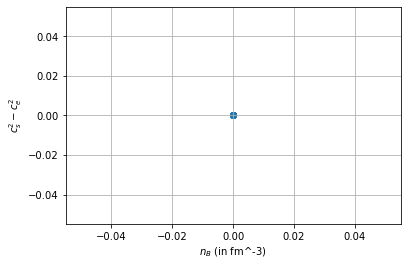

In [48]:
plt.scatter(nb_data*0.16, sound_diff)
plt.xlabel('$n_B$ (in fm^-3)')
plt.grid(True)
plt.ylabel('$c_s^2 - c_e^2$')
plt.show()

# Trouble Shooting

## Chemical Potential Calculations
- Checking to see if chemical potentials (just the potentials, not the derivatives) satisfy beta equilibrium conditions. This would tell us immediately if we have an issue somewhere. And we find that the chemical potentials do not vanish. The issue is more severe in the $\mu_n - \mu_\Lambda$ case which is a problem. Wrong coupling constants? Wrong Lagrangian?  Wrong expression for chemical potentials?
- Answer: The difference is actually neglible. And the difference for neutrons and lambda hyperon is signficant but only prior to the appearance of lambda hyperons, ie, for lower densities. I'm not sure how this would arise mathematically... 

In [61]:
neutron_chem_pot = np.empty(700)
proton_chem_pot = np.empty(700)
lambda_chem_pot = np.empty(700)
electron_chem_pot = np.empty(700)

xe_diff = np.empty(700)
xl_diff = np.empty(700)

In [62]:
for i in range(len(neutron_chem_pot)):
    load_values(i)
    neutron_chem_pot[i] = baryon_chemical_potential(neutron_num)
    proton_chem_pot[i] = baryon_chemical_potential(proton_num)
    lambda_chem_pot[i] = baryon_chemical_potential(lambda_num)
    electron_chem_pot[i] = lepton_chemical_potential(electron_num)

In [63]:
for i in range(len(neutron_chem_pot)):
    xe_diff[i] = neutron_chem_pot[i] - proton_chem_pot[i] - electron_chem_pot[i]
    xl_diff[i] = neutron_chem_pot[i] - lambda_chem_pot[i]

In [64]:
xe_diff

array([-1.12995232e-04, -1.10971544e-04, -1.08896804e-04, -1.03152170e-04,
       -9.95008134e-05, -1.03194239e-04, -9.63662604e-05, -9.50614393e-05,
       -9.10855700e-05, -9.33061277e-05, -8.71450254e-05, -8.37949616e-05,
       -8.43163820e-05, -8.53588163e-05, -8.26950757e-05, -8.05185517e-05,
       -7.79214935e-05, -7.91610857e-05, -7.45676837e-05, -7.32882846e-05,
       -7.35672526e-05, -7.45469671e-05, -7.03525931e-05, -6.90630578e-05,
       -6.44535316e-05, -6.82717012e-05, -6.44131617e-05, -6.70768719e-05,
       -6.89769727e-05, -6.57520928e-05, -6.34725877e-05, -5.76938543e-05,
       -6.26898397e-05, -5.87356945e-05, -6.00710845e-05, -5.66796823e-05,
       -5.48330963e-05, -5.45092668e-05, -5.40589575e-05, -5.26766475e-05,
       -5.94319834e-05, -5.60623716e-05, -5.32920184e-05, -5.05073040e-05,
       -4.96780160e-05, -5.10506232e-05, -4.90583129e-05, -5.27596977e-05,
       -4.82371918e-05, -5.38664026e-05, -4.72959179e-05, -4.79793368e-05,
       -5.14785132e-05, -

In [65]:
xl_diff

array([-1.55350538e+02, -1.54723559e+02, -1.54095944e+02, -1.53467593e+02,
       -1.52838423e+02, -1.52208358e+02, -1.51577327e+02, -1.50945281e+02,
       -1.50312177e+02, -1.49677973e+02, -1.49042631e+02, -1.48406127e+02,
       -1.47768448e+02, -1.47129571e+02, -1.46489474e+02, -1.45848155e+02,
       -1.45205604e+02, -1.44561819e+02, -1.43916796e+02, -1.43270530e+02,
       -1.42623028e+02, -1.41974294e+02, -1.41324325e+02, -1.40673134e+02,
       -1.40020720e+02, -1.39367100e+02, -1.38712272e+02, -1.38056251e+02,
       -1.37399051e+02, -1.36740669e+02, -1.36081119e+02, -1.35420418e+02,
       -1.34758578e+02, -1.34095601e+02, -1.33431504e+02, -1.32766296e+02,
       -1.32099990e+02, -1.31432599e+02, -1.30764134e+02, -1.30094601e+02,
       -1.29424023e+02, -1.28752397e+02, -1.28079748e+02, -1.27406075e+02,
       -1.26731399e+02, -1.26055727e+02, -1.25379069e+02, -1.24701443e+02,
       -1.24022843e+02, -1.23343298e+02, -1.22662805e+02, -1.21981382e+02,
       -1.21299040e+02, -

In [75]:
xl_diff[219]

-8.533446589353844e-06

In [82]:
xl_diff[217]

-1.075133172889764e-05